In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import joblib

In [2]:
# Load the dataset
df = pd.read_csv('/content/amazon_products.csv')

# Initial inspection
print(f"Dataset shape: {df.shape}")
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

Dataset shape: (35810, 11)

Data types:
 asin                  object
title                 object
imgUrl                object
productURL            object
stars                float64
reviews              float64
price                float64
listPrice            float64
category_id          float64
isBestSeller          object
boughtInLastMonth    float64
dtype: object

Missing values:
 asin                 0
title                0
imgUrl               0
productURL           1
stars                1
reviews              1
price                1
listPrice            1
category_id          1
isBestSeller         1
boughtInLastMonth    1
dtype: int64


In [3]:
# Handle missing values properly (without chained assignment)
df = df.copy()  # Create a copy to avoid SettingWithCopyWarning

# Fill missing values
median_stars = df['stars'].median()
median_price = df['price'].median()

df['stars'] = df['stars'].fillna(median_stars)
df['reviews'] = df['reviews'].fillna(0)
df['price'] = df['price'].fillna(median_price)
df['listPrice'] = df['listPrice'].fillna(0)

# Convert boolean to numeric properly
df['isBestSeller'] = df['isBestSeller'].map({True: 1, False: 0})

# Create new features
df['discount_pct'] = np.where(df['listPrice'] > 0,
                            (df['listPrice'] - df['price']) / df['listPrice'],
                            0)
df['price_per_star'] = np.where(df['stars'] > 0,
                              df['price'] / df['stars'],
                              0)
df['review_density'] = df['reviews'] / (df['boughtInLastMonth'].replace(0, 1))  # Avoid division by zero

# Log transform skewed numerical features
df['log_reviews'] = np.log1p(df['reviews'])
df['log_bought'] = np.log1p(df['boughtInLastMonth'])

# Extract product title length
df['title_length'] = df['title'].str.len()

# Handle infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()  # Remove any remaining rows with NaN values

# Verify cleaning
print("\nMissing values after cleaning:", df.isnull().sum().sum())
print("Infinite values after cleaning:", np.isinf(df.select_dtypes(include=[np.number])).sum().sum())


Missing values after cleaning: 0
Infinite values after cleaning: 0


              price         stars  reviews  boughtInLastMonth
count  35809.000000  35809.000000  35809.0       35809.000000
mean      65.351640      4.092223      0.0          42.212852
std       68.248919      1.134161      0.0         244.989220
min        0.000000      0.000000      0.0           0.000000
25%       24.950000      4.200000      0.0           0.000000
50%       41.990000      4.400000      0.0           0.000000
75%       87.990000      4.600000      0.0           0.000000
max     2953.760000      5.000000      0.0       10000.000000

Best seller counts:
 isBestSeller
0.0    35660
1.0      149
Name: count, dtype: int64

Top categories:
 category_id
110.0    17070
114.0    14382
245.0     3433
104.0      924
Name: count, dtype: int64


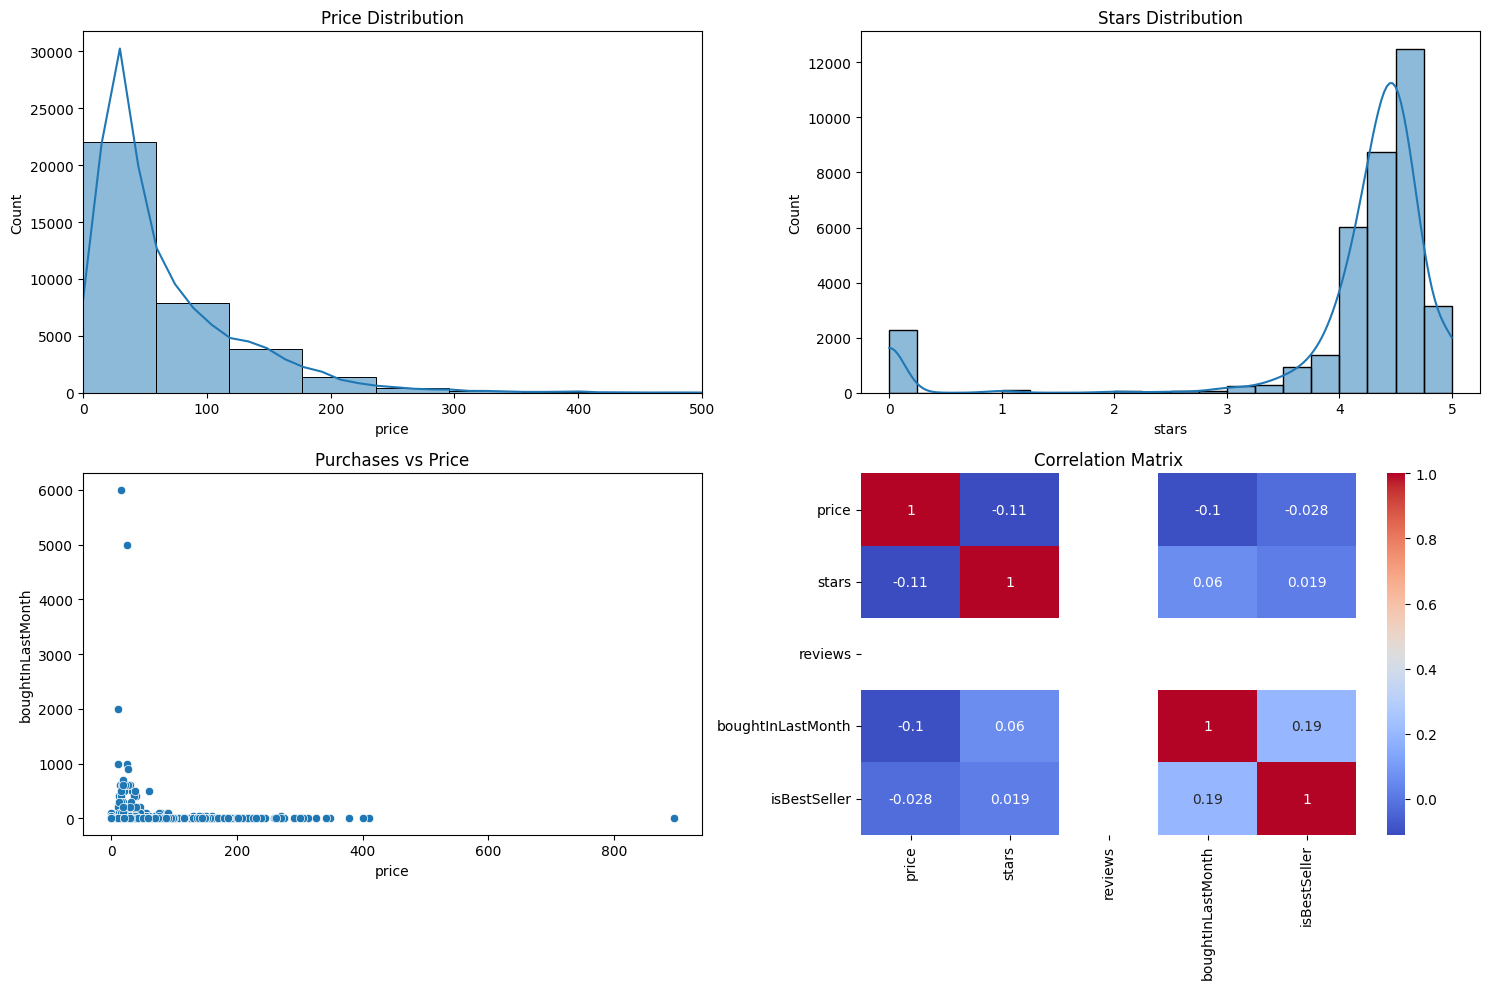

In [4]:
# Numerical features summary
print(df[['price', 'stars', 'reviews', 'boughtInLastMonth']].describe())

# Categorical features analysis
print("\nBest seller counts:\n", df['isBestSeller'].value_counts())
print("\nTop categories:\n", df['category_id'].value_counts().head(10))

# Visualizations
plt.figure(figsize=(15, 10))

# Price distribution
plt.subplot(2, 2, 1)
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.xlim(0, 500)  # Limit to see main distribution

# Stars distribution
plt.subplot(2, 2, 2)
sns.histplot(df['stars'], bins=20, kde=True)
plt.title('Stars Distribution')

# Bought last month vs price
plt.subplot(2, 2, 3)
sns.scatterplot(x='price', y='boughtInLastMonth', data=df.sample(1000))
plt.title('Purchases vs Price')

# Correlation heatmap
plt.subplot(2, 2, 4)
corr = df[['price', 'stars', 'reviews', 'boughtInLastMonth', 'isBestSeller']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()

In [5]:
# Select final features for modeling
features = ['stars', 'reviews', 'listPrice', 'isBestSeller', 'category_id',
           'discount_pct', 'price_per_star', 'review_density', 'title_length']

X = df[features]
y = df['boughtInLastMonth']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Verify no missing/infinite values in final data
print("Final check - Missing in X_train:", X_train.isnull().sum().sum())
print("Final check - Infinite in X_train:", np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum())
print("Final check - Missing in y_train:", y_train.isnull().sum())

Final check - Missing in X_train: 0
Final check - Infinite in X_train: 0
Final check - Missing in y_train: 0


In [6]:
# Define preprocessing
numeric_features = ['stars', 'reviews', 'listPrice', 'discount_pct',
                   'price_per_star', 'review_density', 'title_length']
categorical_features = ['isBestSeller', 'category_id']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder='drop')

# Create model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))])

Mean Absolute Error: 58.71
Root Mean Squared Error: 237.72


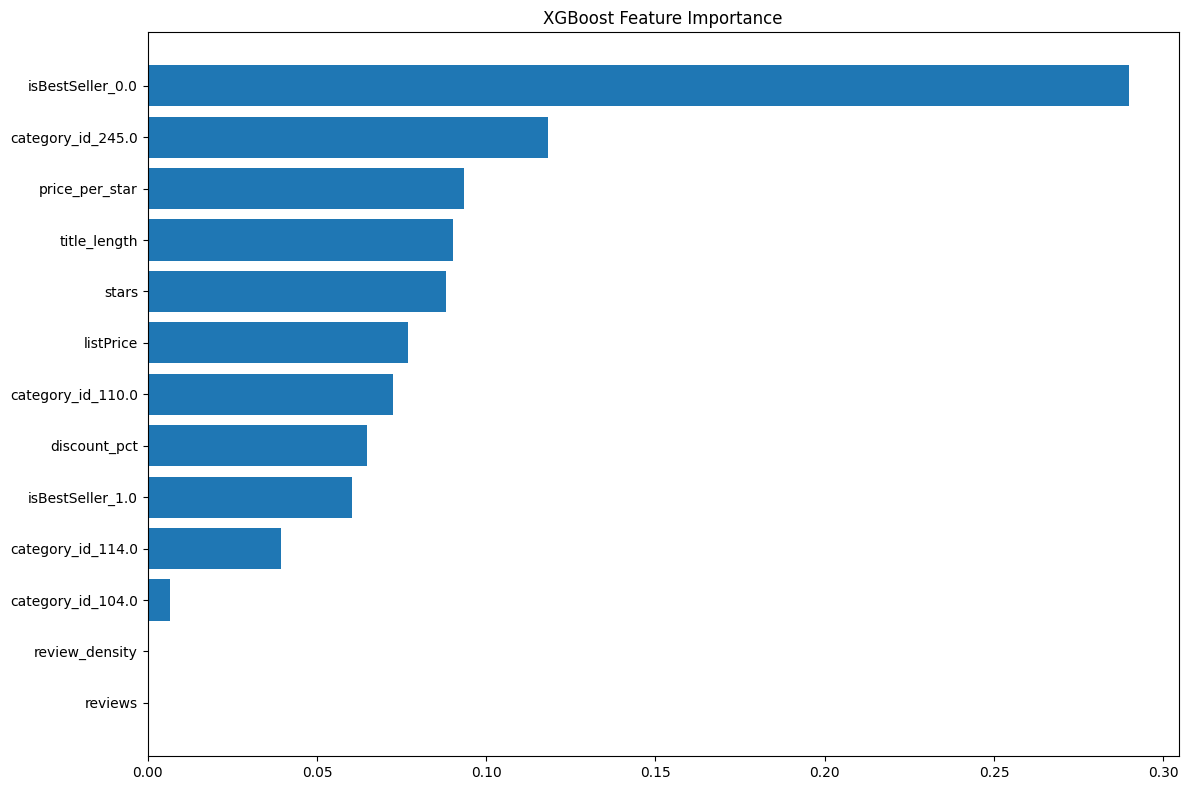

In [7]:
# Train the model
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)

print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

# Feature importance
xgb_model = model.named_steps['regressor']
feature_names = numeric_features + \
               list(model.named_steps['preprocessor'].named_transformers_['cat'] \
                   .named_steps['onehot'].get_feature_names_out(categorical_features))

plt.figure(figsize=(12, 8))
sorted_idx = xgb_model.feature_importances_.argsort()
plt.barh(np.array(feature_names)[sorted_idx], xgb_model.feature_importances_[sorted_idx])
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

Current price: $12.89
Optimal price: $14.81


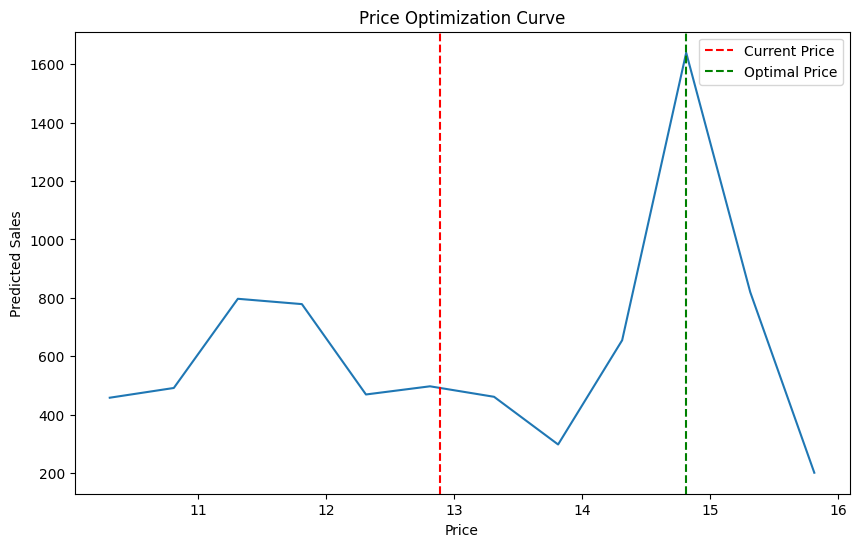

In [9]:
def calculate_optimal_price(model, product_features, current_price, min_price, max_price, step=0.5):
    """
    Find the price that maximizes predicted sales within constraints
    """
    best_price = current_price
    best_predicted_sales = 0
    prices_tested = []
    sales_predicted = []

    # Create a copy of the product features to modify
    product_df = product_features.copy()

    # Get the scalar listPrice value (instead of Series)
    original_list_price = product_df['listPrice'].values[0]

    # Test prices in the range
    for price in np.arange(min_price, max_price + step, step):
        product_df['price'] = price
        # Compare scalar values instead of Series
        product_df['listPrice'] = max(original_list_price, price)  # Ensure listPrice >= price
        product_df['discount_pct'] = np.where(product_df['listPrice'] > 0,
                                            (product_df['listPrice'] - price) / product_df['listPrice'],
                                            0)
        product_df['price_per_star'] = np.where(product_df['stars'] > 0,
                                              price / product_df['stars'],
                                              0)

        predicted_sales = model.predict(product_df)[0]
        prices_tested.append(price)
        sales_predicted.append(predicted_sales)

        if predicted_sales > best_predicted_sales:
            best_predicted_sales = predicted_sales
            best_price = price

    return best_price, prices_tested, sales_predicted

# Example usage:
sample_product = X_test.iloc[[0]].copy()
current_price = df.loc[sample_product.index[0], 'price']
min_price = current_price * 0.8  # 20% discount floor
max_price = current_price * 1.2  # 20% premium ceiling

optimal_price, prices, sales = calculate_optimal_price(model, sample_product, current_price, min_price, max_price)

print(f"Current price: ${current_price:.2f}")
print(f"Optimal price: ${optimal_price:.2f}")

# Plot price vs predicted sales
plt.figure(figsize=(10, 6))
plt.plot(prices, sales)
plt.axvline(x=current_price, color='r', linestyle='--', label='Current Price')
plt.axvline(x=optimal_price, color='g', linestyle='--', label='Optimal Price')
plt.xlabel('Price')
plt.ylabel('Predicted Sales')
plt.title('Price Optimization Curve')
plt.legend()
plt.show()

In [10]:
# Save the entire pipeline
joblib.dump(model, 'dynamic_pricing_model.pkl')

# Example of loading and using the model
loaded_model = joblib.load('dynamic_pricing_model.pkl')

# Create a function for real-time price adjustment
def get_dynamic_price(product_data, current_price, strategy='max_sales'):
    """
    product_data: Dictionary containing product features
    strategy: 'max_sales', 'max_revenue', or 'clear_inventory'
    """
    # Convert to DataFrame
    product_df = pd.DataFrame([product_data])

    # Predict base demand
    base_demand = loaded_model.predict(product_df)[0]

    # Different pricing strategies
    if strategy == 'max_sales':
        # Simple strategy - small discount from current price
        return current_price * 0.95  # 5% discount
    elif strategy == 'max_revenue':
        # More complex strategy considering elasticity
        elasticity = -1.5  # Assumed price elasticity
        optimal_price = current_price * (1 + 1/elasticity)
        return max(optimal_price, current_price * 0.8)  # Don't go below 20% discount
    elif strategy == 'clear_inventory':
        # Aggressive discounting
        return current_price * 0.7  # 30% discount
    else:
        return current_price

# Example usage
product_example = {
    'stars': 4.5,
    'reviews': 100,
    'listPrice': 49.99,
    'isBestSeller': 1,
    'category_id': 104,
    'discount_pct': 0.2,
    'price_per_star': 10,
    'review_density': 0.5,
    'title_length': 50
}

print("Suggested price:", get_dynamic_price(product_example, 39.99, strategy='max_revenue'))

Suggested price: 31.992000000000004
